# Training: Checkpoints, Logging, and Callbacks
In this notebook we will cover a quickstart training of the Split Delivery Vehicle Routing Problem (SDVRP), with some additional comments along the way. The SDVRP is a variant of the VRP where a vehicle can deliver a part of the demand of a customer and return later to deliver the rest of the demand.

## Installation
Uncomment the following line to install the package from PyPI. Remember to choose a GPU runtime for faster training!

| Note: You may need to restart the runtime in Colab after this

In [1]:
!pip install rl4co -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.1/336.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 988.0/988.0 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 54.5 MB/s eta 0:

## Imports

In [2]:
import torch
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary

from rl4co.envs import SDVRPEnv
from rl4co.models.zoo import AttentionModel
from rl4co.utils.trainer import RL4COTrainer

## Main Setup

### Environment, Model, and LitModule

In [3]:
# RL4CO env based on TorchRL
env = SDVRPEnv(
    generator_params=dict(num_loc=20)
)

# Model: default is AN with REINFORCE and greedy rollout baseline
model = AttentionModel(
    env=env,
    baseline="rollout",
    train_data_size=100_000, # really small size for demo
    val_data_size=10_000
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


### Test greedy rollout with untrained model and plot

Tour lengths: ['16.29', '14.61', '21.43']


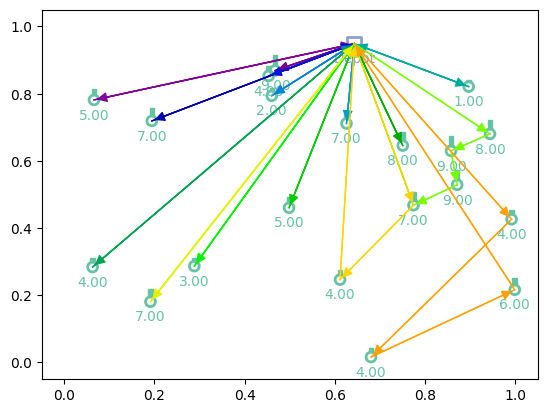

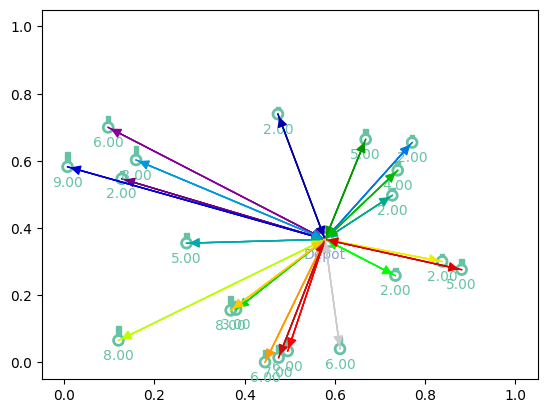

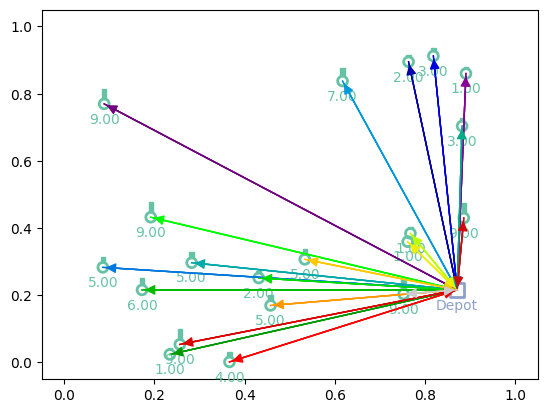

In [4]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = model.policy.to(device)
out = policy(
    td_init.clone(),
    env,
    phase="test",
    decode_type="greedy",
    return_actions=True
)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

## Training
    

### Callbacks
Here we set up a checkpoint callback to save the best model and another callback for demonstration (nice progress bar). You may check other callbacks [here](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html)

In [5]:
#checkpointing callback: save models when validation reward improves
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints", # save to checkpoints/
    filename="epoch_{epoch:03d}", # save as epoch_XXX.ckpt
    save_top_k=1, # save the best model
    save_last=True, # save the last model
    monitor="val/reward", # monitor validation reward
    mode="max" # maximize validation reward
)

# Print model summary
rich_model_summary = RichModelSummary(max_depth=3)

# Callbacks list
callbacks = [checkpoint_callback, rich_model_summary]

### Logging
Here we will use Wandb. You may comment below lines if you don't want to use it. You may check other loggers [here](https://lightning.ai/docs/pytorch/stable/extensions/logging.html)

We make sure we're logged into W&B so that our experiments can be associated with our account. You may comment the below line if you don't want to use it.

In [29]:
import wandb
wandb.login(
    # key="mykey",
    relogin=True,
    force=True
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [33]:
#Comment following two lines if you don't want logging
from lightning.pytorch.loggers import WandbLogger

run = wandb.init(
    entity="OptiMap",
    mode="online",
    project="test",
    name="advrp-cv"
)

logger = WandbLogger()

### Trainer
The RL4CO trainer is a wrapper around PyTorch Lightning's Trainer class which adds some functionality and more efficient defaults

The Trainer handles the logging, checkpointing and more for you.

In [43]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=100,
    accelerator="gpu",
    devices=-1,
    logger=logger,
    callbacks=callbacks
)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Fit the model

In [44]:
trainer.fit(model)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name                                   ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ env                                    │ SDVRPEnv              │      0 │ train │
│ 1  │ policy                                 │ AttentionModelPolicy  │  694 K │ train │
│ 2  │ policy.encoder                         │ AttentionModelEncoder │  595 K │ train │
│ 3  │ policy.encoder.init_embedding          │ VRPInitEmbedding      │    896 │ train │
│ 4  │ policy.encoder.net                     │ GraphAttentionNetwork │  594 K │ train │
│ 5  │ policy.decoder                         │ AttentionModelDecoder │ 98.8 K │ train │
│ 6  │ policy.decoder.context_embedding       │ VRPContext            │ 16.5 K │ train │
│ 7  │ policy.decoder.dynamic_embedding       │ SDVRPDynamicEmbedding │    384 │ train │
│ 8  │ policy.decoder.pointer                 │ PointerAttention      │ 16.4 K │ train │
│ 9  │ policy.decoder.project_node_embeddings │ Linear                │ 49.2 K │ train │
│ 10 │ policy.decoder.project_fixed_context   │ Linear                │ 16.4 K │ train │
│ 11 │ baseline                               │ WarmupBaseline        │  694 K │ train │
│ 12 │ baseline.baseline                      │ RolloutBaseline       │  694 K │ train │
│ 13 │ baseline.baseline.policy               │ AttentionModelPolicy  │  694 K │ eval  │
│ 14 │ baseline.warmup_baseline               │ ExponentialBaseline   │      0 │ train │
└────┴────────────────────────────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 74                                                                                          
Modules in eval mode: 70

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tour lengths: ['8.65', '5.27', '7.06']


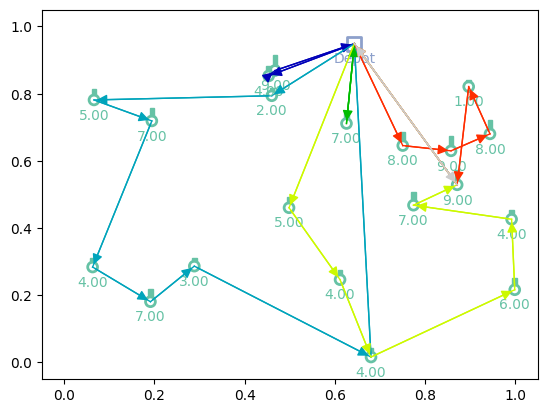

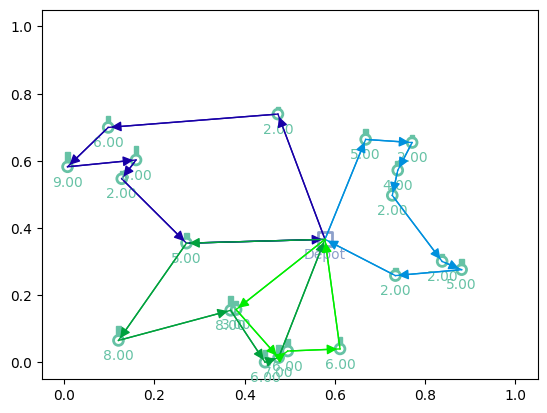

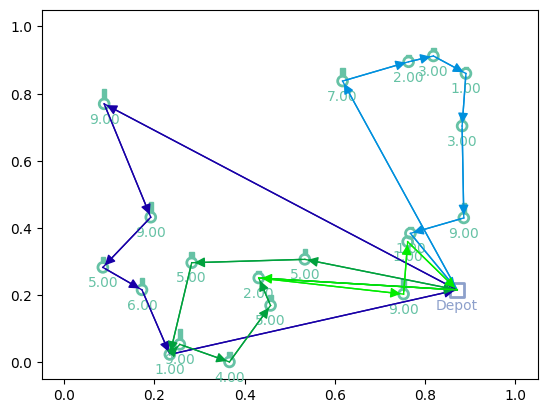

In [36]:
# Greedy rollouts over trained model (same states as prvious plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

## Test function
By default the dataset is generated or loaded by the environment. You may load a dataset by setting `test_file` during the env config.
```python
env = SDVRPEnv(
    ...
    test_file="path/to/test/file"
)
```
In this case, we test directly on the generated test dataset

In [37]:
trainer.test(model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │    -7.3791069984436035    │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': -7.3791069984436035}]

## Test generalization to new dataset
Here we can load a new dataset (with 50 nodes) and test the trained model on it

In [39]:
# Test generalization to 50 nodes (not going to be great due to few epochs, but hey)
env = SDVRPEnv(generator_params=dict(num_loc=50))

# Generate data (100) and set as test dataset
new_dataset = env.dataset(50)
dataloader = model._dataloader(new_dataset, batch_size=100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Plotting generalization

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tour lengths: ['17.20', '24.27', '13.64']


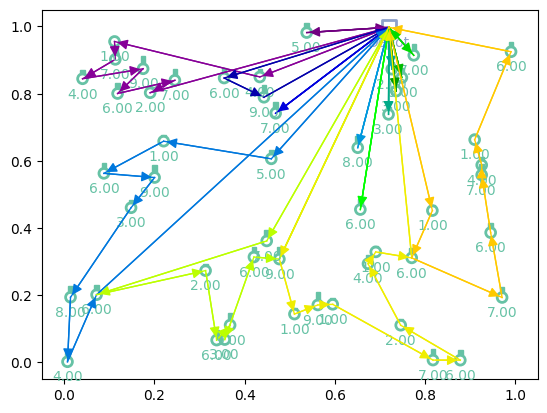

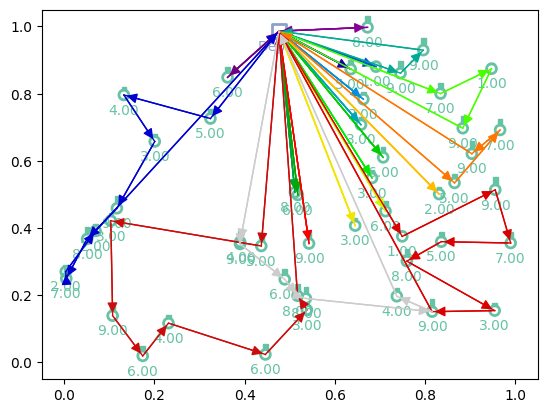

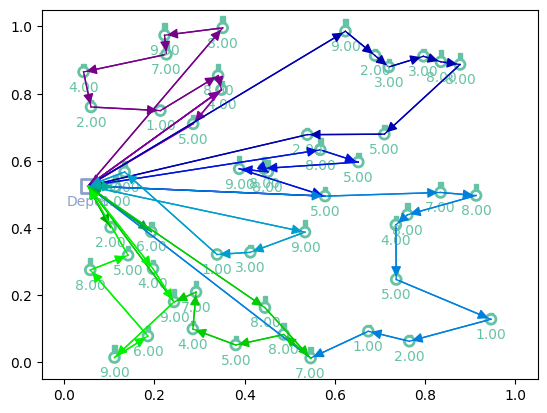

In [40]:
# Greedy rollouts over trained policy (same states as previous plot, with 20 nodes)
init_states = next(iter(dataloader))[:3]
td_init_generalization = env.reset(init_states).to(device)

policy = model.policy.to(device)
out = policy(td_init_generalization.clone(), env, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init_generalization, out['actions'].cpu()):
    env.render(td, actions)

## Loading model
Thanks to PyTorch Lightning, we can easily save and load a model to and from a checkpoint! This is declared in the Trainer using the model checkpoint callback. For example, we can load the last model via the last.ckpt file located in the folder we specified in the Trainer.

In [41]:
# Environment, Model, and Lightning Module (reinstantiate from scratch)
model = AttentionModel(env,
                       baseline="rollout",
                       train_data_size=100_000,
                       test_data_size=10_000,
                       optimizer_kwargs={'lr': 1e-4}
                       )

# Note that by default, Lightning will call checkpoints from newer runs with "-v{version}" suffix
# unless you specify the checkpoint path explicitly
new_model_checkpoint = AttentionModel.load_from_checkpoint("checkpoints/last.ckpt", strict=False)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['baseline.baseline.policy.encoder.init_embedding.init_embed.weight', 'baseline.baseline.policy.encoder.init_embedding.init_embed.bias', 'baseline.baseline.policy.encoder.init_embedding.init_embed_depot.weight', 'baseline.baseline.policy.encoder.init_embedding.init_embed_depot.bias', 'baseline.baseline.policy.encoder.net.layers.0

Tour lengths: ['8.65', '5.27', '7.06']


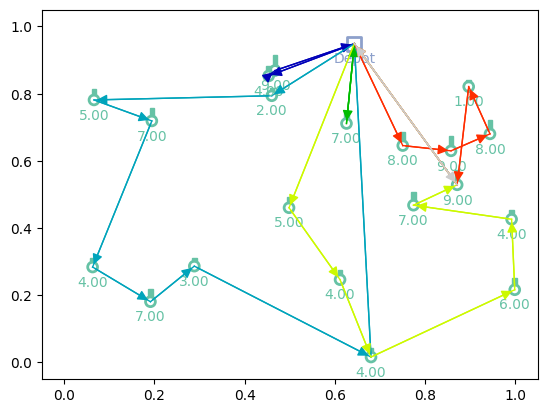

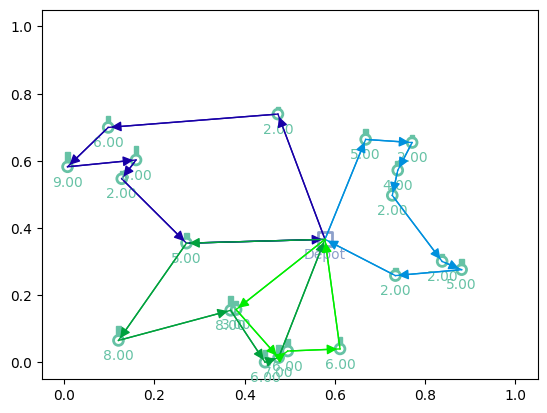

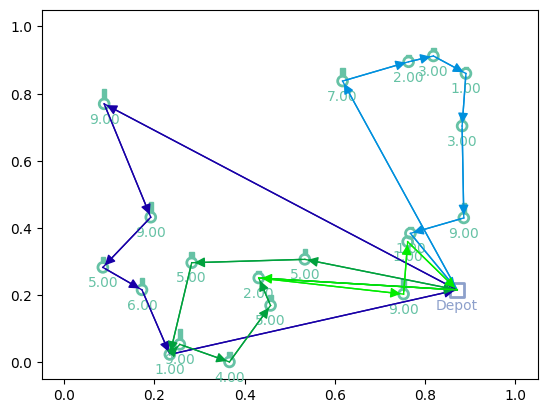

In [42]:
# Greedy rollouts over trained model (same states as previous plot, with 20 nodes)
policy_new = new_model_checkpoint.policy.to(device)
env = new_model_checkpoint.env.to(device)

out = policy_new(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)